In [1]:
import datetime as dt
import pandas as pd
df = pd.read_csv('csv_for_test.csv')
df["date_time"] = pd.to_datetime(df["date_time"])

In [ ]:
# Profit Loss
pl_sum = df["profit_loss"].sum()
print(f"トータル損益\t\t : {pl_sum:,.0f}円")
# Ratio of WIn - Lose
win_sum = df.loc[df["profit_loss"]>=0, "profit_loss"].sum()
lose_sum = df.loc[df["profit_loss"] < 0, "profit_loss"].sum()
print(f"収益合計\t\t\t：{win_sum:,.0f}円")
print(f"損益合計\t\t\t：{lose_sum:,.0f}円")
# Swap PL
swap_total = df.loc[df["trade_category"] == "swap", "profit_loss"].sum()
print(f"スワップ損益合計\t\t：{swap_total:,.0f}円")
# Trade times
entry_cnt = (df["trade_category"] == "entry").sum()
exit_cnt = (df["trade_category"] == "exit").sum()
print(f"エントリー回数\t\t：{entry_cnt:,} 回")
# Count of Win - Lose
win_cnt = df.loc[df["profit_loss"]>0, "profit_loss"].count()
lose_cnt = df.loc[df["profit_loss"] < 0, "profit_loss"].count()
print(f"収益トレード\t\t：{win_cnt:,.0f}回")
print(f"損失トレード\t\t：{lose_cnt:,.0f}回")
print(f"勝率\t\t\t：{win_cnt / (win_cnt + lose_cnt) * 100:,.2f}％")
# Win pips
win_lot = df.loc[df["profit_loss"] > 0, "executed_amount"].sum()
win_pip = win_sum / win_lot
# Lose pips
lose_lot = df.loc[df["profit_loss"] < 0, "executed_amount"].sum()
lose_pip = lose_sum / lose_lot
print(f"収益トレード平均獲得PIPS\t：{win_pip:,.3f}")
print(f"損失トレード平均獲得PIPS\t：{lose_pip:,.3f}")
print(f"Risk Reward Ratio\t：{win_pip/-lose_pip:.2f}")
# Avg lot Win - Lose
win_lot_per_trade = win_lot / win_cnt
lose_lot_per_trade = lose_lot / lose_cnt
print(f"収益トレード平均建玉\t：{win_lot_per_trade:,.0f}通貨")
print(f"損失トレード平均建玉\t：{lose_lot_per_trade:,.0f}通貨")
# Entry bid ask
bid_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "sell")).sum()
ask_entry= ((df["trade_category"] == "entry") & (df["bid_ask"] == "buy")).sum()
print(f"BID ASK エントリー回数\t：Bid => {bid_entry}, Ask => {ask_entry}")

トータル損益		 : 73,650円
収益合計			：547,330円
損益合計			：-473,680円
スワップ損益合計		：0円
エントリー回数		：369 回
収益トレード		：267回
損失トレード		：92回
勝率			：74.37％
収益トレード平均獲得PIPS	：0.016
損失トレード平均獲得PIPS	：-0.044
Risk Reward Ratio	：0.37
収益トレード平均建玉	：126,704通貨
損失トレード平均建玉	：117,500通貨
BID ASK エントリー回数	：Bid => 306, Ask => 63


In [3]:
import sys

# Making set
entry_list = []
exit_list = []
trade_set_list = []

# データのindexをentryとexitのリストに格納
for index, row in df.iterrows():
    if row["trade_category"] == "entry":
        entry_list.append(index)
    elif row["trade_category"] == "exit":
        exit_list.append(index)

# データ数の確認
if (len(entry_list) + len(exit_list)) != len(df):
    print("trade_categoryカラムにentry,exit以外のデータが含まれているようです")
    sys.exit()

used_exit_list = set()
for i in entry_list:
    tmp_list = []
    tmp_sum = 0
    list_on_hold = []
    
    for j in exit_list:
        if j in used_exit_list:
            continue

        # Entry と Exit のペアを正しくマッチング
        if (df.loc[i, "currency_pair"] == df.loc[j, "currency_pair"]) and \
           (df.loc[i, "bid_ask"] != df.loc[j, "bid_ask"]) and \
           (df.loc[i, "executed_price"] == df.loc[j, "entry_price"]):
            # 数量も同じならOKで次へ
            if df.loc[i,"executed_amount"] == df.loc[j, "executed_amount"]:
                tmp_list.append(j)
                used_exit_list.add(j)
                break
            elif df.loc[i,"executed_amount"] < df.loc[j, "executed_amount"]:
                continue
            elif (df.loc[i,"executed_amount"] > df.loc[j, "executed_amount"]) and (df.loc[i,"executed_amount"] == (df.loc[j,"executed_amount"] + tmp_sum)):
                list_on_hold.append(j)
                tmp_list = list_on_hold
                used_exit_list.update(list_on_hold)
                break
            else:
                tmp_sum += df.loc[j, "executed_amount"]
                list_on_hold.append(j) 
                continue
        else:
            continue
        
    trade_set_list.append([i, tmp_list])

In [4]:
columns = [
    "trade_set_list"
    ,"entry_date_time"
    ,"avg_exit_time"
    ,"currency_pair"
    ,"entry_bid_ask"
    ,"entry_amount"
    ,"entry_price"
    ,"avg_exit_price"
    ,"profit_loss"
    ,"hold_time_sec"
    ,"pips"
]

dtypes = {
    "trade_set_list" : object 
    ,"entry_date_time" : "datetime64[ns]"
    ,"avg_exit_time" : "datetime64[ns]"
    ,"currency_pair" : str
    ,"entry_bid_ask" : str
    ,"entry_amount" : float
    ,"entry_price" : float
    ,"avg_exit_price" : float
    ,"profit_loss" : float
    ,"hold_time_sec" : float
    ,"pips" : float
}
# 空のデータフレームを作成
trade_df = pd.DataFrame(columns=columns).astype(dtypes)

In [5]:
data_list = []
for l in trade_set_list:
    tmp_list = []
    
    # trade_set_list
    nested_tuple = tuple(tuple(x) if isinstance(x, list) else x for x in l)
    tmp_list.append(nested_tuple)
    
    # entry_date_time
    entry_time = df.loc[l[0],"date_time"]
    tmp_list.append(entry_time)
    
    # avg_exit_time ( calc )
    # 平均を取りたい date_time の行を選択（例えば index 0, 1, 2, 3）
    selected_dates = df.loc[l[1], "date_time"]
    # 選択した date_time の平均
    mean_date_time = selected_dates.mean()
    exit_time = mean_date_time
    tmp_list.append(exit_time)
    
    # currency_pair
    tmp_list.append(df.loc[l[0],"currency_pair"])
    
    # entry_bid_ask
    tmp_list.append(df.loc[l[0],"bid_ask"])
    
    # entry_amount
    entry_amount = df.loc[l[0],"executed_amount"]
    tmp_list.append(entry_amount)
    
    # entry_price
    entry_price = df.loc[l[0],"executed_price"]
    tmp_list.append(entry_price)
    
    # avg_exit_price ( calc )
    sum = 0.0
    for i in l[1]:
        sum += df.loc[i,"executed_price"]
    avg_exit_price = sum/len(l[1])
    tmp_list.append(avg_exit_price)

    # sum_profit_loss
    sum_profit_loss = 0.0
    for i in l[1]:
        sum_profit_loss += df.loc[i,"profit_loss"]
    tmp_list.append(sum_profit_loss)

    # hold_time_sec
    # 差分を秒単位で取得し、小数点以下2桁で丸める
    diff_seconds = round((exit_time - entry_time).total_seconds(), 2)
    tmp_list.append(diff_seconds)
    
    # pips
    pips = sum_profit_loss / entry_amount
    tmp_list.append(pips)
        
    data_list.append(tmp_list)

In [6]:
# trade_dfにdata_listを代入
for i, row in enumerate(data_list):
    trade_df.loc[i] = pd.Series(row, index=trade_df.columns)
# すべての行を入れ終わったら改めて型を指定
trade_df = trade_df.astype(dtypes)

- 獲得PIPS
- 獲得PIPS数ヒストグラム

In [7]:
import matplotlib.pyplot as plt

In [8]:
print(trade_df["pips"].sum())
print(trade_df["pips"].mean())
print(trade_df["pips"].max())
print(trade_df["pips"].min())


-0.23699999999999988
-0.0006422764227642273
0.129
-0.252


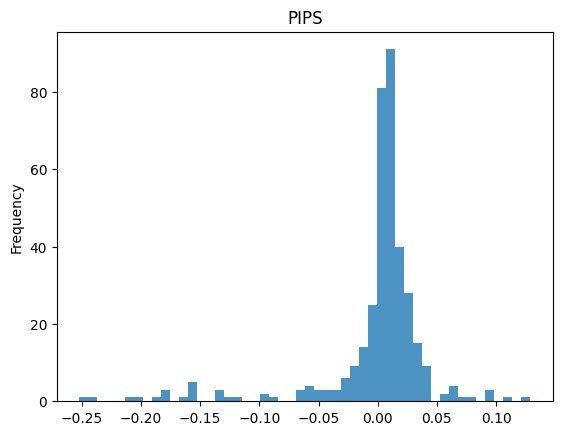

In [9]:
trade_df["pips"].plot.hist(title='PIPS', bins=50, alpha=0.8)
plt.show()

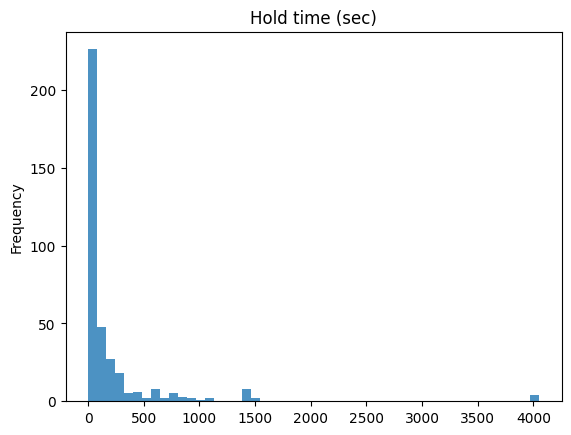

In [10]:
trade_df["hold_time_sec"].plot.hist(title='Hold time (sec)', bins=50, alpha=0.8)
plt.show()

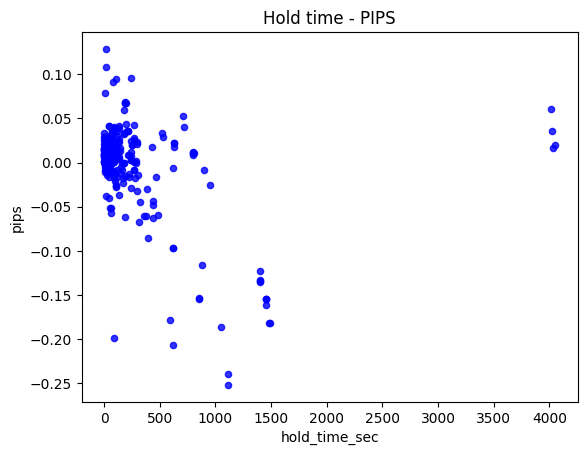

In [11]:
# 散布図を作成
trade_df[["hold_time_sec","pips"]].plot.scatter(title = "Hold time - PIPS", x="hold_time_sec", y="pips", alpha=0.8, color="blue")

# 表示
plt.show()


In [12]:
trade_df

,trade_set_list,entry_date_time,avg_exit_time,currency_pair,entry_bid_ask,entry_amount,entry_price,avg_exit_price,profit_loss,hold_time_sec,pips
0,"(0, (1,))",2025-02-03 09:55:25,2025-02-03 09:55:57,USDJPY,sell,120000.0,155.644,155.622,2640.0,32.0,0.022
1,"(2, (3,))",2025-02-03 09:56:15,2025-02-03 09:56:51,USDJPY,sell,120000.0,155.649,155.624,3000.0,36.0,0.025
2,"(4, (15,))",2025-02-03 09:57:38,2025-02-03 10:00:45,USDJPY,sell,120000.0,155.607,155.669,-7440.0,187.0,-0.062
3,"(5, (14,))",2025-02-03 09:57:57,2025-02-03 10:00:45,USDJPY,sell,120000.0,155.646,155.669,-2760.0,168.0,-0.023
4,"(6, (10,))",2025-02-03 09:58:20,2025-02-03 10:00:45,USDJPY,sell,120000.0,155.682,155.669,1560.0,145.0,0.013
...,...,...,...,...,...,...,...,...,...,...,...
364,"(728, (729,))",2025-02-04 00:54:56,2025-02-04 00:55:41,USDJPY,sell,70000.0,154.671,154.668,210.0,45.0,0.003
365,"(730, (731,))",2025-02-04 00:56:08,2025-02-04 00:56:10,USDJPY,sell,90000.0,154.701,154.691,900.0,2.0,0.010
366,"(732, (733,))",2025-02-04 01:06:11,2025-02-04 01:06:16,USDJPY,sell,50000.0,154.680,154.673,350.0,5.0,0.007
367,"(734, (735,))",2025-02-04 01:06:21,2025-02-04 01:06:25,USDJPY,sell,150000.0,154.693,154.670,3450.0,4.0,0.023
